# Details

|   Name      |   Date   |  Revison |            Comments                                                                      |
|-------------|----------|----------|------------------------------------------------------------------------------------------|
| David Baker | 15/10/24 |    0.01  | Initial background discussion & change in project scope (discussed with line management) |
| David Baker | 15/10/24 |    0.02  | Download of data from hugging face into the local system |
| David Baker | 15/10/24 |    0.03  | Plotting code to visualise the mask, multi band image and sentinal-2 individual band images |
| David Baker | 15/10/24 |    0.04  | Discussion section on the architecture of the model UNet vs Autoencoder |
| David Baker | 15/10/24 |    0.05  | Discussion section on the architecture of the UNet Downsampling path. Still `TODO` max pooling |
| David Baker | 15/10/24 |    0.06  | Started PyTorch model creation by constructing the `Dataset` class to be used by the `Dataloader` |
| David Baker | 15/10/24 |    0.07  | Statistic on the number of labels with/without a mask in the training dataset to assess class imbalance |
| David Baker | 15/10/24 |    0.08  | Setup follow on section about Algal Blooms in Lough Neagh Northern Ireland |
| David Baker | 15/10/24 |    0.09  | Added code to extract 100x100 regions of interest out of the mask, mbmp and s2 images as per paper |
| David Baker | 15/10/24 |    0.10  | Utilised ChatGPT GPT-4o to create the UNet architecture based on the description provided in the paper |
| David Baker | 15/10/24 |    0.11  | Issue encountered when running with device 'mps' so for now set device to 'cpu' and raised a `TODO` issue |
| David Baker | 23/10/24 |    0.12  | Used `torch.set_default_device(device)` after torch import instead of `.to(device)` to rectify issue |
| David Baker | 23/10/24 |    0.13  | Setup the optimiser (Adam), learning rate and loss function (Binary Cross Entropy) for the model |
| David Baker | 23/10/24 |    0.14  | Reconfigure the dataloader to load in a batch size and also perform shuffling |
| David Baker | 23/10/24 |    0.15  | Put in some verbosity printing statements|
| David Baker | 23/10/24 |    0.16  | The S2 ROI tensor was shaped (1,100,100,12) for a batch size of 1, needed to reshape to (1,12,100,100) to fit model format |
| David Baker | 23/10/24 |    0.17  | The S2 ROI tensor was in integer format needed to convert to float uint8 to be compatible with model |
| David Baker | 24/10/24 |    0.18  | Looking into training and class imbalance, reducing the supplied dataset to more balanced example |
| David Baker | `TODO`   |    `TODO`  | Checked in to Git the initial version of notebook, datasets arent uploaded to public github but made available on the cluster |

# Introduction
This notebook has been created as part of the UKSA Data and AI training course Phase 3 project element as part of the University of Portsmouth training.

In this notebook I shall be replicating the process of creating and training a neural network from scratch in pytorch based on the dataset presented in the paper CH4Net: a deep learning model for monitoring methane super-emitters with Sentinel-2 imagery by Anna Vaughan, Gonzalo Mateo-García, Luis Gómez-Chova, Vít Růžička, Luis Guanter, and Itziar Irakulis-Loitxate cited as:
``Vaughan, A., Mateo-García, G., Gómez-Chova, L., Růžička, V., Guanter, L., and Irakulis-Loitxate, I.: CH4Net: a deep learning model for monitoring methane super-emitters with Sentinel-2 imagery, Atmos. Meas. Tech., 17, 2583–2593, https://doi.org/10.5194/amt-17-2583-2024, 2024.`` (https://doi.org/10.5194/amt-17-2583-2024)

In this paper the authors have used data from Sentinal 2 to automate the process of monitoring methane super-emitters. The question they posed was "For a known set of methane super-emitters, is it possible to accurately identify plumes in Sentinal-2 imagery to monitor future emissions?"

For this purpose they constructed a machine learning model to segment methane plumes from a single image.

The aims of the paper were as follows:
1. Collect and label a machine learning dataset of methane plumes in Sentinal-2 imagery
2. Develop an automated plume segmentation system. In contrast to existing works the authors indented to design a fully automated system that does not require a time series of Sentinel-2 images or identification of a reference image at the test time.
3. Apply the system to track emissions from a selection of known methan super-emitters during a future time period.

For the purposes of this training I am to replicate, with the knowledge gained from the practical hands on sessions, part 2 of this papers approach. That is, using data collected by the authors in part 1. I aim to construct a Pytorch model to examine the construction of the U-Net used to encode/decode the image and produce preditictions against the target masks created by the authors during their annotation phase. 


References:
* Data available at Hugging Face per https://huggingface.co/datasets/av555/ch4net (Vaughan, A.: ch4net (Revision 568db19), Hugging Face, https://doi.org/10.57967/hf/2117, 2024)
* Sentinal 2 data available https://www.sentinel-hub.com/ from Sentinel Hub (2024) 
* Code produced by the author available in https://github.com/annavaughan/CH4Net/tree/main has also been utilised as a source of inspiration for performing this work.


## Background

This section of the notebook shows how to visualise the data contained within the test/train/val datasets splits provided by the original authors. The data has been stored in a series of numpy memmaps<sup>1</sup>. Each train/test/validation folder then is futher sub divided by folders containing the following:

- MBMP: multiband multipass differencing 
- Label: hand annotated masks
- S2: the 12 raw Sentinel-2 bands 

Each image is assinged a unique numerical identification number eg 123. The code below shows how to load each image and provides a visulisation of the content of each.

<sup>1</sup> A numpy memmap, or memory-mapped file is used for accessing small segments of a large file on disk, without reading the entire file into memory. Numpy's memmaps's are array-like objects. Memory-mapped files cannot be larger than 2GB on 32-bit systems.

---
### 0. Issues
* Running locally on M1 Macbook device is determined to be MPS but there is a conflict with PyTorch when using .to('mps') so for now have reset to use .to('cpu'). This will have to be addresed before attempting to run on the cluster where cuda will be available. Might only use 'cuda' and 'cpu' as options when determining device rather than also hoping to include 'mps'

---
### 1. Exploratory Data Analysis

In [3]:
# Visulise the data contained in the numpy memmaped files
# for the train, test and validation dataset splits.
import os
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

image_id = 1673  # Chosen unique image ID 1673

# Set the relative file paths to the dataset
label_path = f"ch4net/test/label/{image_id}.npy"
mbmp_path = f"ch4net/test/mbmp/{image_id}.npy"
s2_path = f"ch4net/test/s2/{image_id}.npy"

# Using np.load() load each files memmaped content in 
# and assign to a variable
label = np.load(label_path)
mbmp = np.load(mbmp_path)
s2 = np.load(s2_path)

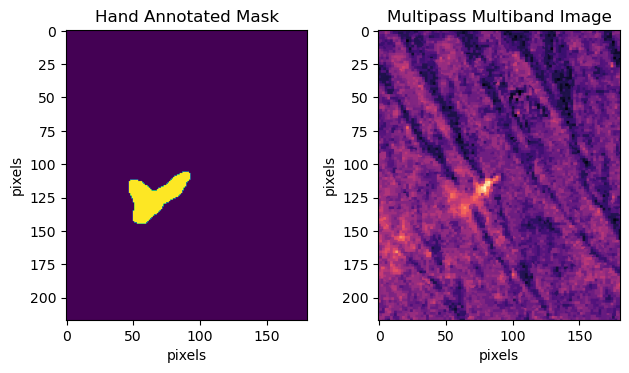

In [4]:
# Plot the hand annoted mask and the multiband multipass image (mbmp)
# The mask is a combination of binary 0,1 data (True for mask location)
plt.subplot(1, 2, 1)
plt.title("Hand Annotated Mask")
plt.imshow(label)
plt.xlabel('pixels')
plt.ylabel('pixels')

plt.subplot(1,2,2)
plt.title("Multipass Multiband Image")
plt.imshow(mbmp)
plt.xlabel('pixels')
plt.ylabel('pixels')

plt.tight_layout()
plt.show()

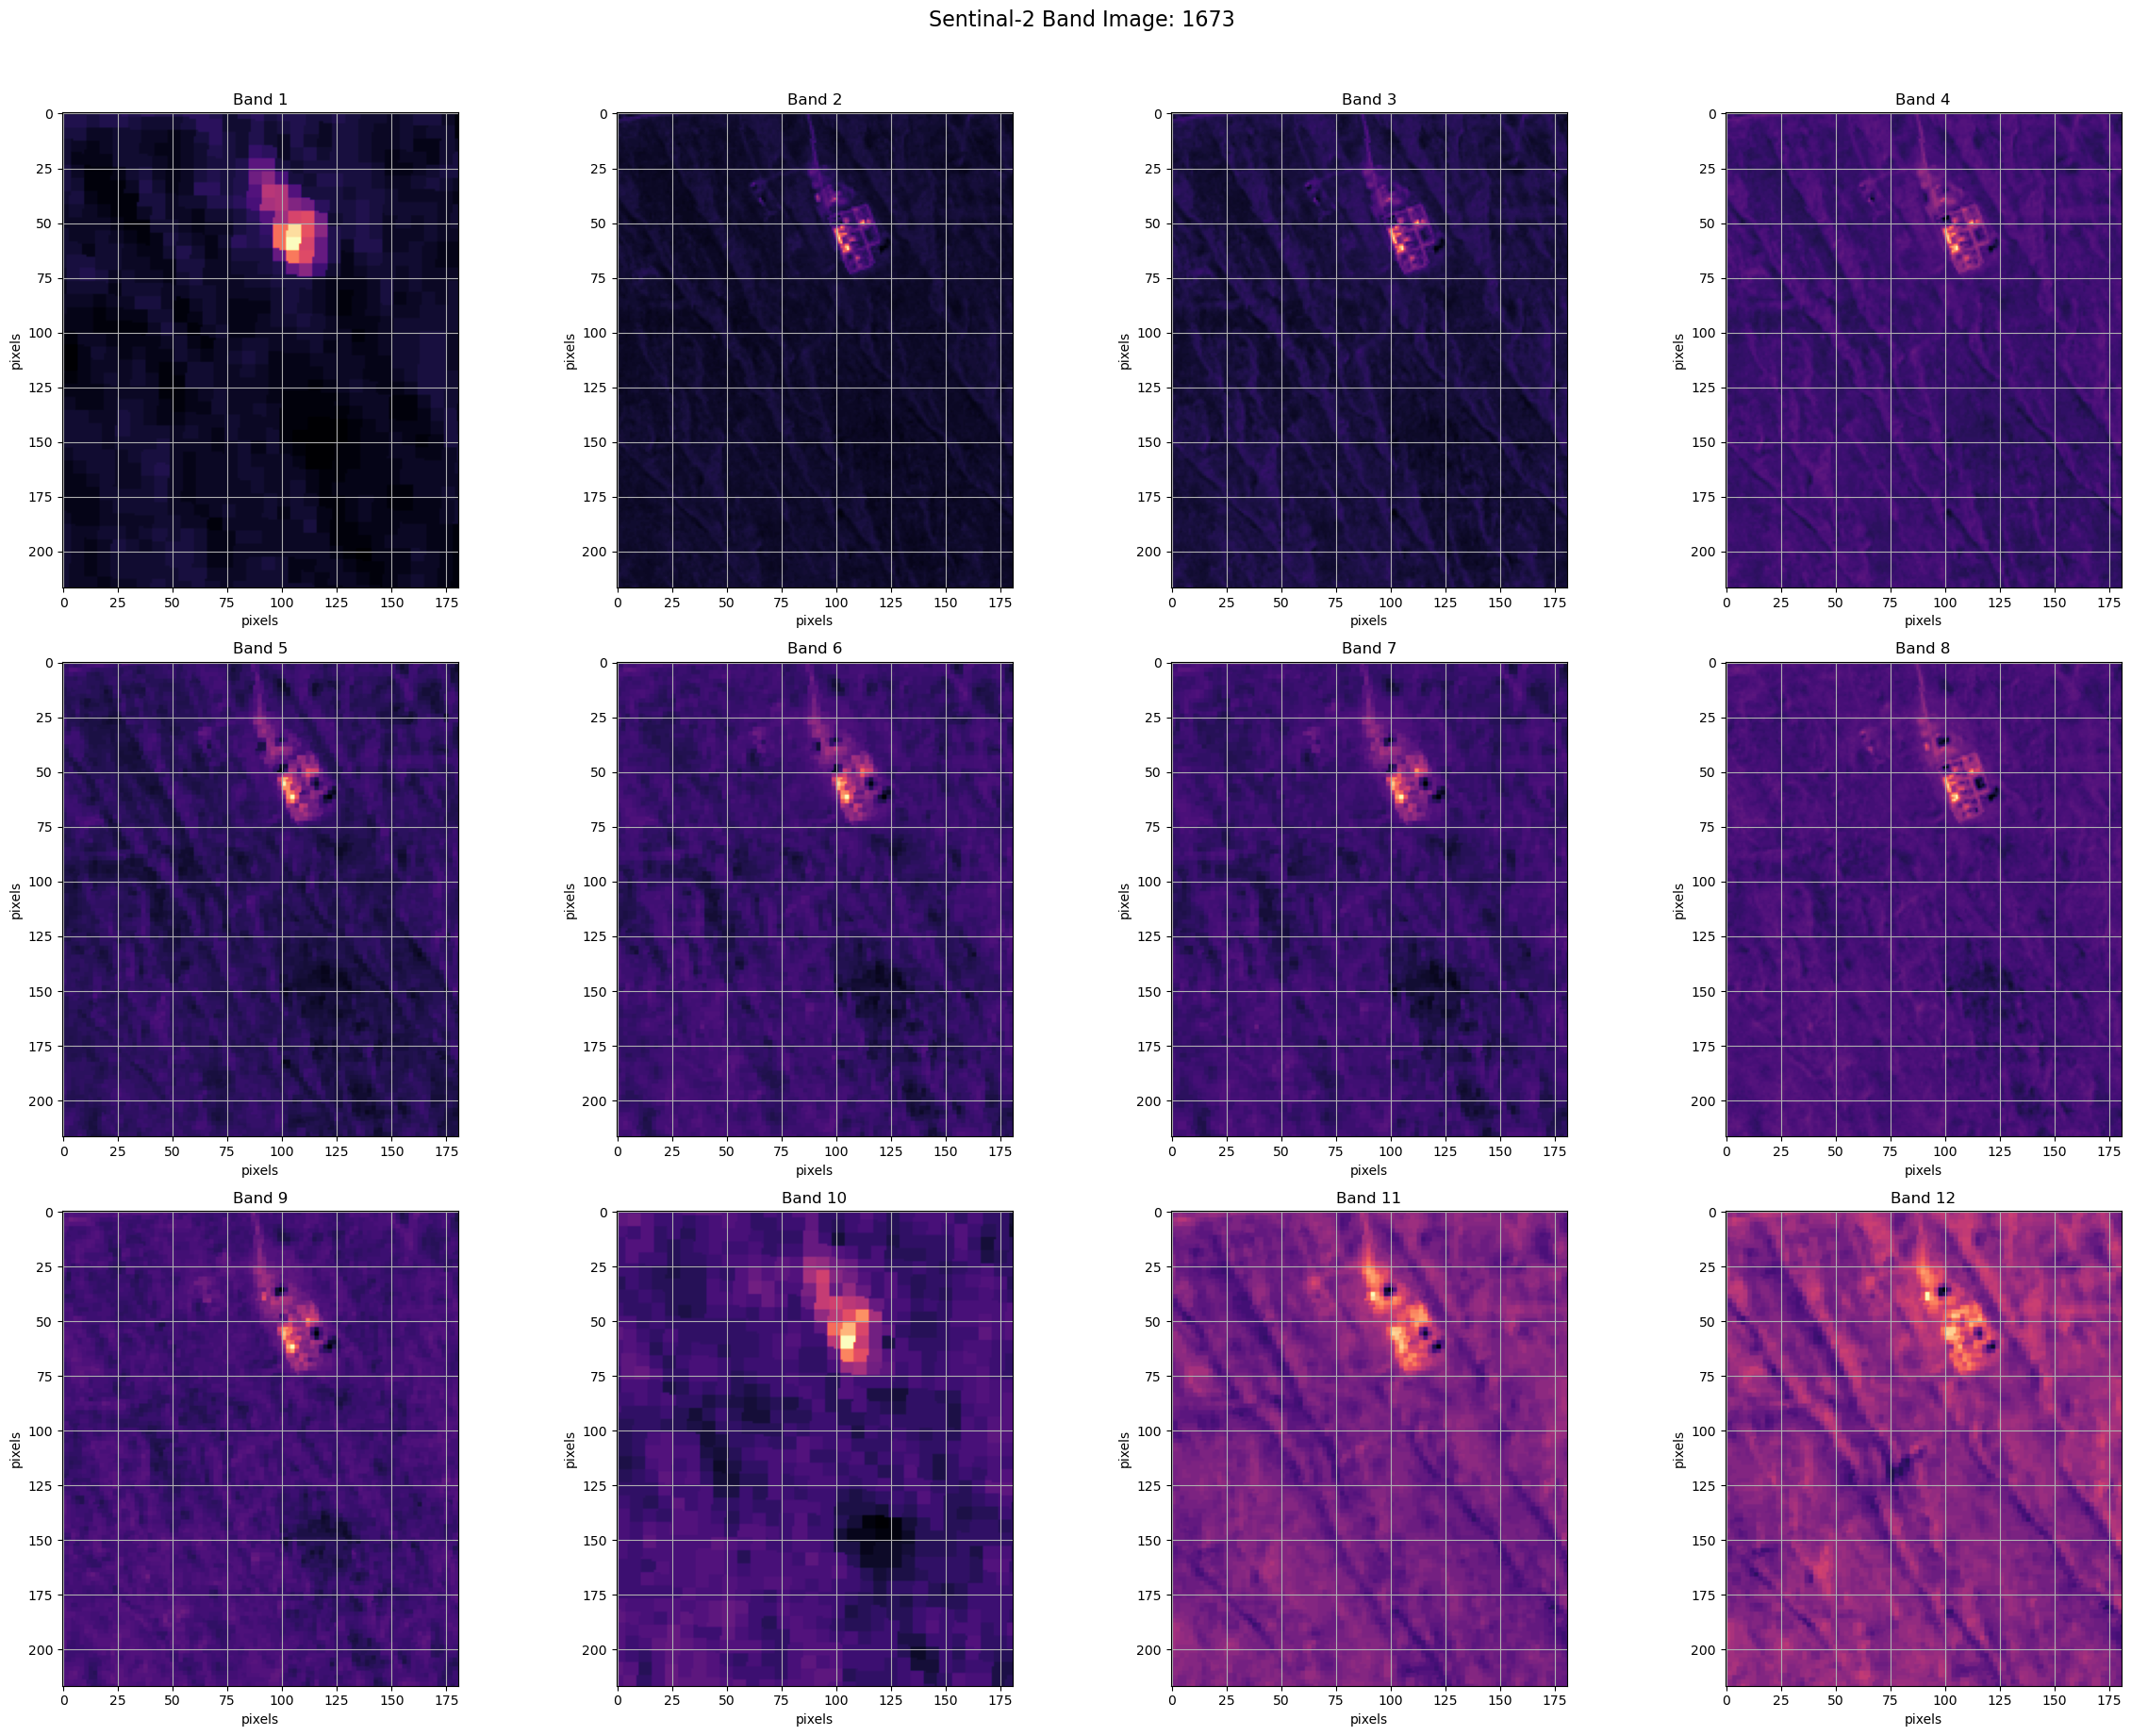

In [5]:
# Now plot the same image from the Sentinal 2 data showing each band
ratio = 0.5 # Used to help scale the plot size for display on screen
fig, axes = plt.subplots(3, 4, figsize=(12/ratio,9/ratio))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Loop through the images and display them on the grid
for band in range(1,13):
    axes[band-1].imshow(s2[...,band-1],cmap="magma")
    axes[band-1].axis('on')  # Hide axes for cleaner look
    axes[band-1].set_title('Band {}'.format(band))
    axes[band-1].set_xlabel("pixels")
    axes[band-1].set_ylabel("pixels")
    axes[band-1].grid("minor")

# Adjust layout
plt.suptitle("Sentinal-2 Band Image: {}".format(image_id), fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.tight_layout()
plt.show()

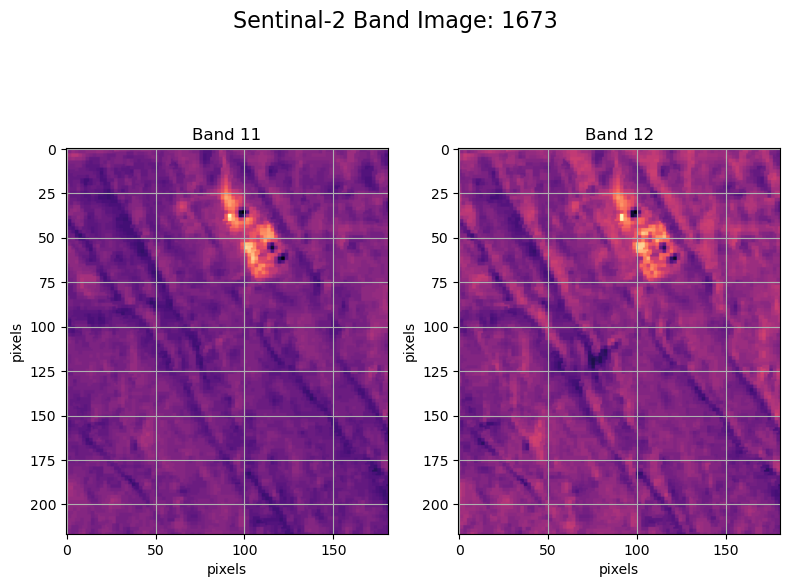

In [10]:
# Now plot the same image from the Sentinal 2 data showing only bands 11 and 12
ratio = 1.5 # Used to help scale the plot size for display on screen
fig, axes = plt.subplots(1, 2, figsize=(12/ratio,9/ratio))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Loop through the images and display them on the grid
for band in range(11,13):
    axes[band-11].imshow(s2[...,band-1],cmap="magma")
    axes[band-11].axis('on')  # Hide axes for cleaner look
    axes[band-11].set_title('Band {}'.format(band))
    axes[band-11].set_xlabel("pixels")
    axes[band-11].set_ylabel("pixels")
    axes[band-11].grid("minor")

# Adjust layout
plt.suptitle("Sentinal-2 Band Image: {}".format(image_id), fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.tight_layout()
plt.show()

In [20]:
# Write each of the plotting code blocks as functions for reuse later on
def plot_mask(label):
    """
    Plot the mask
    """
    plt.title("Hand Annotated Mask")
    plt.imshow(label)
    plt.xlabel('pixels')
    plt.ylabel('pixels')

def plot_mbmp(mbmp):
    """
    Plot the Multipass Multiband Image
    """
    plt.title("Multipass Multiband Image")
    plt.imshow(mbmp)
    plt.xlabel('pixels')
    plt.ylabel('pixels')

def plot_s2(s2):
    """
    Plot each of the 12 Sentinal bands
    """
    ratio = 0.5
    fig, axes = plt.subplots(3, 4, figsize=(12/ratio,9/ratio))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Loop through the images and display them on the grid
    for band in range(1,13):
        axes[band-1].imshow(s2[...,band-1],cmap="magma")
        axes[band-1].axis('on')  # Hide axes for cleaner look
        axes[band-1].set_title('Band {}'.format(band))
        axes[band-1].set_xlabel("pixels")
        axes[band-1].set_ylabel("pixels")
        axes[band-1].grid("minor")

    # Adjust layout
    plt.suptitle("Sentinal-2 Band Image: {}".format(image_id), fontsize=16, y=1.02)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.tight_layout()
    plt.show()

def plot_mbmp_masked(mbmp,label):
    """
    Plot the Multiband Multipass image with the mask overlaid
    """
    fig, ax = plt.subplots()
    ax.imshow(mbmp, cmap='gray', interpolation='none')
    ax.imshow(np.ma.masked_where(~label, label), cmap='Reds', interpolation='none', alpha=0.35)
    plt.suptitle("Multipass Multiband Image", fontsize=16, y=1.02)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    plt.show()

def plot_s2_masked(s2,label):
    """
    Plot each of the 12 Sentinal bands with the mask overlaid
    """
    ratio = 0.5
    fig, axes = plt.subplots(3, 4, figsize=(12/ratio,9/ratio))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Loop through the images and display them on the grid
    for band in range(1,13):
        axes[band-1].imshow(s2[...,band-1],cmap="magma")
        axes[band-1].imshow(np.ma.masked_where(~label, label), cmap='Greys', interpolation='none', alpha=0.35)
        axes[band-1].axis('on')  # Hide axes for cleaner look
        axes[band-1].set_title('Band {}'.format(band))
        axes[band-1].set_xlabel("pixels")
        axes[band-1].set_ylabel("pixels")
        axes[band-1].grid("minor")

    # Adjust layout
    plt.suptitle("Sentinal-2 Band Image: {}".format(image_id), fontsize=16, y=1.02)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.tight_layout()
    plt.show()

def plot_s2_rgb(s2):
    """
    Plot an RGB image from the Sentinal bands
    """
    ratio = 1
    band_2_norm = s2[...,1]
    band_3_norm = s2[...,2]
    band_4_norm = s2[...,3]

    rgb_image = np.dstack((band_4_norm, band_3_norm, band_2_norm)).astype(np.uint8)
    fig, ax = plt.subplots(figsize=(12/ratio,9/ratio))
    plt.imshow(rgb_image)
    plt.title("RGB Image from Sentinel-2 Data")
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    plt.show()

def plot_s2_11_12_masked(s2,label):
    """
    Plot Sentinal Bands 11 and 12 with the mask overlaid
    """
    ratio = 0.5
    fig, axes = plt.subplots(1, 2, figsize=(12/ratio,9/ratio))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Loop through the images and display them on the grid
    for band in range(11,13):
        axes[band-11].imshow(s2[...,band-1],cmap="magma")
        axes[band-11].imshow(np.ma.masked_where(~label, label), cmap='Greys', interpolation='none', alpha=0.35)
        axes[band-11].axis('on')  # Hide axes for cleaner look
        axes[band-11].set_title('Band {}'.format(band))
        axes[band-11].set_xlabel("pixels")
        axes[band-11].set_ylabel("pixels")
        axes[band-11].grid("minor")

    # Adjust layout
    plt.suptitle("Sentinal-2 Band Image: {}".format(image_id), fontsize=16, y=1.02)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.tight_layout()
    plt.show()

---

In [21]:
import glob
file_count = glob.glob("ch4net/*/label/*.npy")
print("Number of files: {}".format(len(file_count)))

Number of files: 10983


The authors paper claims a dataset of `925` scenes containing a plume and `9121` without for a total of `10046` images. However a file count of the label `*.npy` files in the test train and validation set comes out with `10983` files. **This needs exploring**.

_Also as a note: 
The authors describe the split of training, test and validation data as follows. training set is all images from 2017 to 2020 excluding the validation set. The validation set is a held out randomly sampled selection of 256 train images stratified by plume presence. The test set is all images from 2021._

In [22]:
modes = ['test','train','val']
for mode in modes:
    files = glob.glob("ch4net/{}/label/*.npy".format(mode))
    count_mask = 0
    with_mask = []
    for i in range(0,len(files)):
        label_file = np.load(files[i])
        if not np.all(label_file == 0):
            count_mask = count_mask+1
            with_mask.append(str.split(str.split(files[i],'/')[-1],'.npy')[0])

    print("Total number of {} files: {}".format(mode,len(files)+1))
    print("Percentage of {} files with a mask: {:.3f}%".format(mode,(count_mask/len(files))*100))
    print('\n')



Total number of test files: 2474
Percentage of test files with a mask: 11.120%


Total number of train files: 8256
Percentage of train files with a mask: 7.256%


Total number of val files: 256
Percentage of val files with a mask: 48.235%




Given there are only two options, mask or no-mask and we have ~7.3% with a mask this means the dataset is quite heavily unbalanced in terms of its data classes. Later methods of training the neural network may want to attempt to account/compensate for this. `TODO: Methods to account for class imbalance`. The validation set does indeed look more balanced.

Currently the data is held in the following structure where there is a mixture of positive and negative catagories

````
ch4net/
├─ test/
│  ├─ label/
│  ├─ mbmp/
│  ├─ s2/
├─ train/
│  ├─ label/
│  ├─ mbmp/
│  ├─ s2/
├─ val/
│  ├─ label/
│  ├─ mbmp/
│  ├─ s2/
````

Instead lets split them out into positive and negative classes in the training and test datasets. Only moving them if a label, mask and s2 image exists (just in case there isnt a common set, ie an s2 set exists but not a label). Also note only working with the labels and s2 images not the multipass multiband images. As the classes are heavily imbalanced take 200 from the test and training (100 positive, 100 negative)

```
ch4net/
├─ split_test/
│  ├─ positive/
│  |  ├─ label/
│  |  ├─ s2/
│  ├─ negative/
│  |  ├─ label/
│  |  ├─ s2/
├─ split_train/
│  ├─ positive/
│  |  ├─ label/
│  |  ├─ s2/
│  ├─ negative/
│  |  ├─ label/
│  |  ├─ s2/

```

In [24]:
import shutil
# Create some temporary directories using the test and train data
# Split out the positive and negative instances 
# Use this to potentially help rebalance the dataset when training
# As can make sure the ones with a mask get used alongside an
# equal number of positive images.

# Evaluate the distribution of masks within the training dataset
modes = ['train','test']

for mode in modes:
    os.makedirs('ch4net/split_{}/label/positive'.format(mode), exist_ok=True)
    os.makedirs('ch4net/split_{}/label/negative'.format(mode), exist_ok=True)

    os.makedirs('ch4net/split_{}/s2/positive'.format(mode), exist_ok=True)
    os.makedirs('ch4net/split_{}/s2/negative'.format(mode), exist_ok=True)


for mode in modes:
    pos_counter = 0
    neg_counter = 0
    image_paths = [os.path.join(root, file)
                for root, _, files in os.walk(os.path.join('ch4net',mode))
                for file in files if file.endswith('.npy')]
    numerical_parts = ([int(file.split('/')[-1].rstrip('.npy')) for file in image_paths])
    common_set = list(set(item for item in numerical_parts if numerical_parts.count(item) == 3))


    for c in common_set:
        label_file = np.load("ch4net/{}/label/{}.npy".format(mode,c))
        if not np.all(label_file == 0):
            if pos_counter < 100:
                # File has mask copy to pos
                shutil.copy("ch4net/{}/label/{}.npy".format(mode,c), "ch4net/split_{}/label/positive/{}.npy".format(mode,c))
                shutil.copy("ch4net/{}/s2/{}.npy".format(mode,c), "ch4net/split_{}/s2/positive/{}.npy".format(mode,c))
                pos_counter = pos_counter +1
        else:
            if neg_counter < 100:
                shutil.copy("ch4net/{}/label/{}.npy".format(mode,c), "ch4net/split_{}/label/negative/{}.npy".format(mode,c))
                shutil.copy("ch4net/{}/s2/{}.npy".format(mode,c), "ch4net/split_{}/s2/negative/{}.npy".format(mode,c))
                neg_counter = neg_counter + 1

In [31]:
modes = ['test','train']
for mode in modes:
    files = glob.glob("ch4net/split_{}/label/*/*.npy".format(mode))
    count_mask = 0
    with_mask = []
    for i in range(0,len(files)):
        label_file = np.load(files[i])

        if not np.all(label_file == 0):
            count_mask = count_mask+1
            with_mask.append(str.split(str.split(files[i],'/')[-1],'.npy')[0])

    print("Total number of {} files: {}".format(mode,len(files)+1))
    print("Percentage of {} files with a mask: {:.3f}%".format(mode,(count_mask/len(files))*100))
    print('\n')

Total number of test files: 201
Percentage of test files with a mask: 50.000%


Total number of train files: 201
Percentage of train files with a mask: 50.000%




---

In [27]:
# Image Details
# Extract some useful image dimension data, this will be required when setting up the Neural Network
mask_image_dimension = label.shape
print("Each Mask Image dimension: {}".format(mask_image_dimension))
mbmp_image_dimension = mbmp.shape
print("Each MBMP Image dimension: {}".format(mbmp_image_dimension))
s2_image_dimension = s2.shape
print("Each S2 Image dimension: {}".format(s2_image_dimension))

Each Mask Image dimension: (217, 181)
Each MBMP Image dimension: (217, 181, 4)
Each S2 Image dimension: (217, 181, 12)


**Note** The image dimensions from the numpy files arent nessiciarly all the same size but they should align between the same mask, mbmp and set of s2 images. The author's paper states they first collected and manually annotaed the Sentinel-2 methane plumes from 2017-2021 that were 0.01 x 0.01 degrees (200x200 pixels). Images were obtained from Sentinel Hub using the Sentinel Hub API. 

**However** it is noted in the methodology section that to prevent overfitting, augmentation is applied by cropping a random 100x100 pixel scene from the larger image tiles. Therefore even in a positive case its possible a non-mask region might be selected when looking at the cropped region.

The same 100x100 region therefore needs to be extracted from all of the s2 band images and the labelled mask image. Also the 100x100 region should be contained within the image ie its desired area should not extend beyong the bounds of the image. Care will be needed to evaluate the validation images as these won't conform to the 100x100 size and so will possibly need to "slide" over these to any detections across the whole image.

In [32]:
def slice_region(mask,s2):
    # Size of the region to slice out
    slice_size = 100
    print(f"Original mask region: {mask.shape}")
    print(f"Original s2 region: {s2.shape}")
    
    if not (mask.shape[0] == s2.shape[0]) or not (mask.shape[1] == s2.shape[1])  :
        raise ValueError(f"Image dimensions of mask and s2 are not the same")

    n, m, d = s2.shape  # Get dimensions
    
    # Ensure that n and m are larger than 100 (the region size)
    if n < slice_size or m < slice_size:
        raise ValueError(f"Array dimensions n ({n}) and m ({m}) must be larger than the slice size ({slice_size}).")

    # Randomly select starting points, ensuring that the region stays within bounds
    start_n = np.random.randint(0, n - slice_size + 1)
    start_m = np.random.randint(0, m - slice_size + 1)

    # Slice the 100x100 region from the array to select the region of interest
    mask_roi = mask[start_n:start_n + slice_size, start_m:start_m + slice_size]
    s2_roi = s2[start_n:start_n + slice_size, start_m:start_m + slice_size, :]
    
    # Print the start and end points of the sliced region for verification
    print(f"Selected region starts at (n={start_n}, m={start_m}) and ends at (n={start_n + slice_size}, m={start_m + slice_size})")
    print(f"Sliced region shape: {s2_roi.shape}")
    return mask_roi, s2_roi

In [40]:
import random
positive_test_files = glob.glob("ch4net/split_test/label/positive/*.npy".format(mode))
positive_test_files_ids = []
for i in range(0,len(positive_test_files)):
    positive_test_files_ids.append(str.split(str.split(positive_test_files[i],'/')[-1],'.npy')[0])

image_id = random.choice(positive_test_files_ids) # Chosen unique random image ID with a mask
print('Image ID: {}'.format(image_id))

# Set the relative file paths to the dataset
label_path = f"ch4net/split_test/label/positive/{image_id}.npy"
s2_path = f"ch4net/split_test/s2/positive/{image_id}.npy"

# Using np.load() load each files memmaped content in 
# and assign to a variable
label = np.load(label_path)
s2 = np.load(s2_path)

mask_roi, s2_roi = slice_region(label,s2)

Image ID: 203
Original mask region: (227, 169)
Original s2 region: (227, 169, 12)
Selected region starts at (n=78, m=43) and ends at (n=178, m=143)
Sliced region shape: (100, 100, 12)


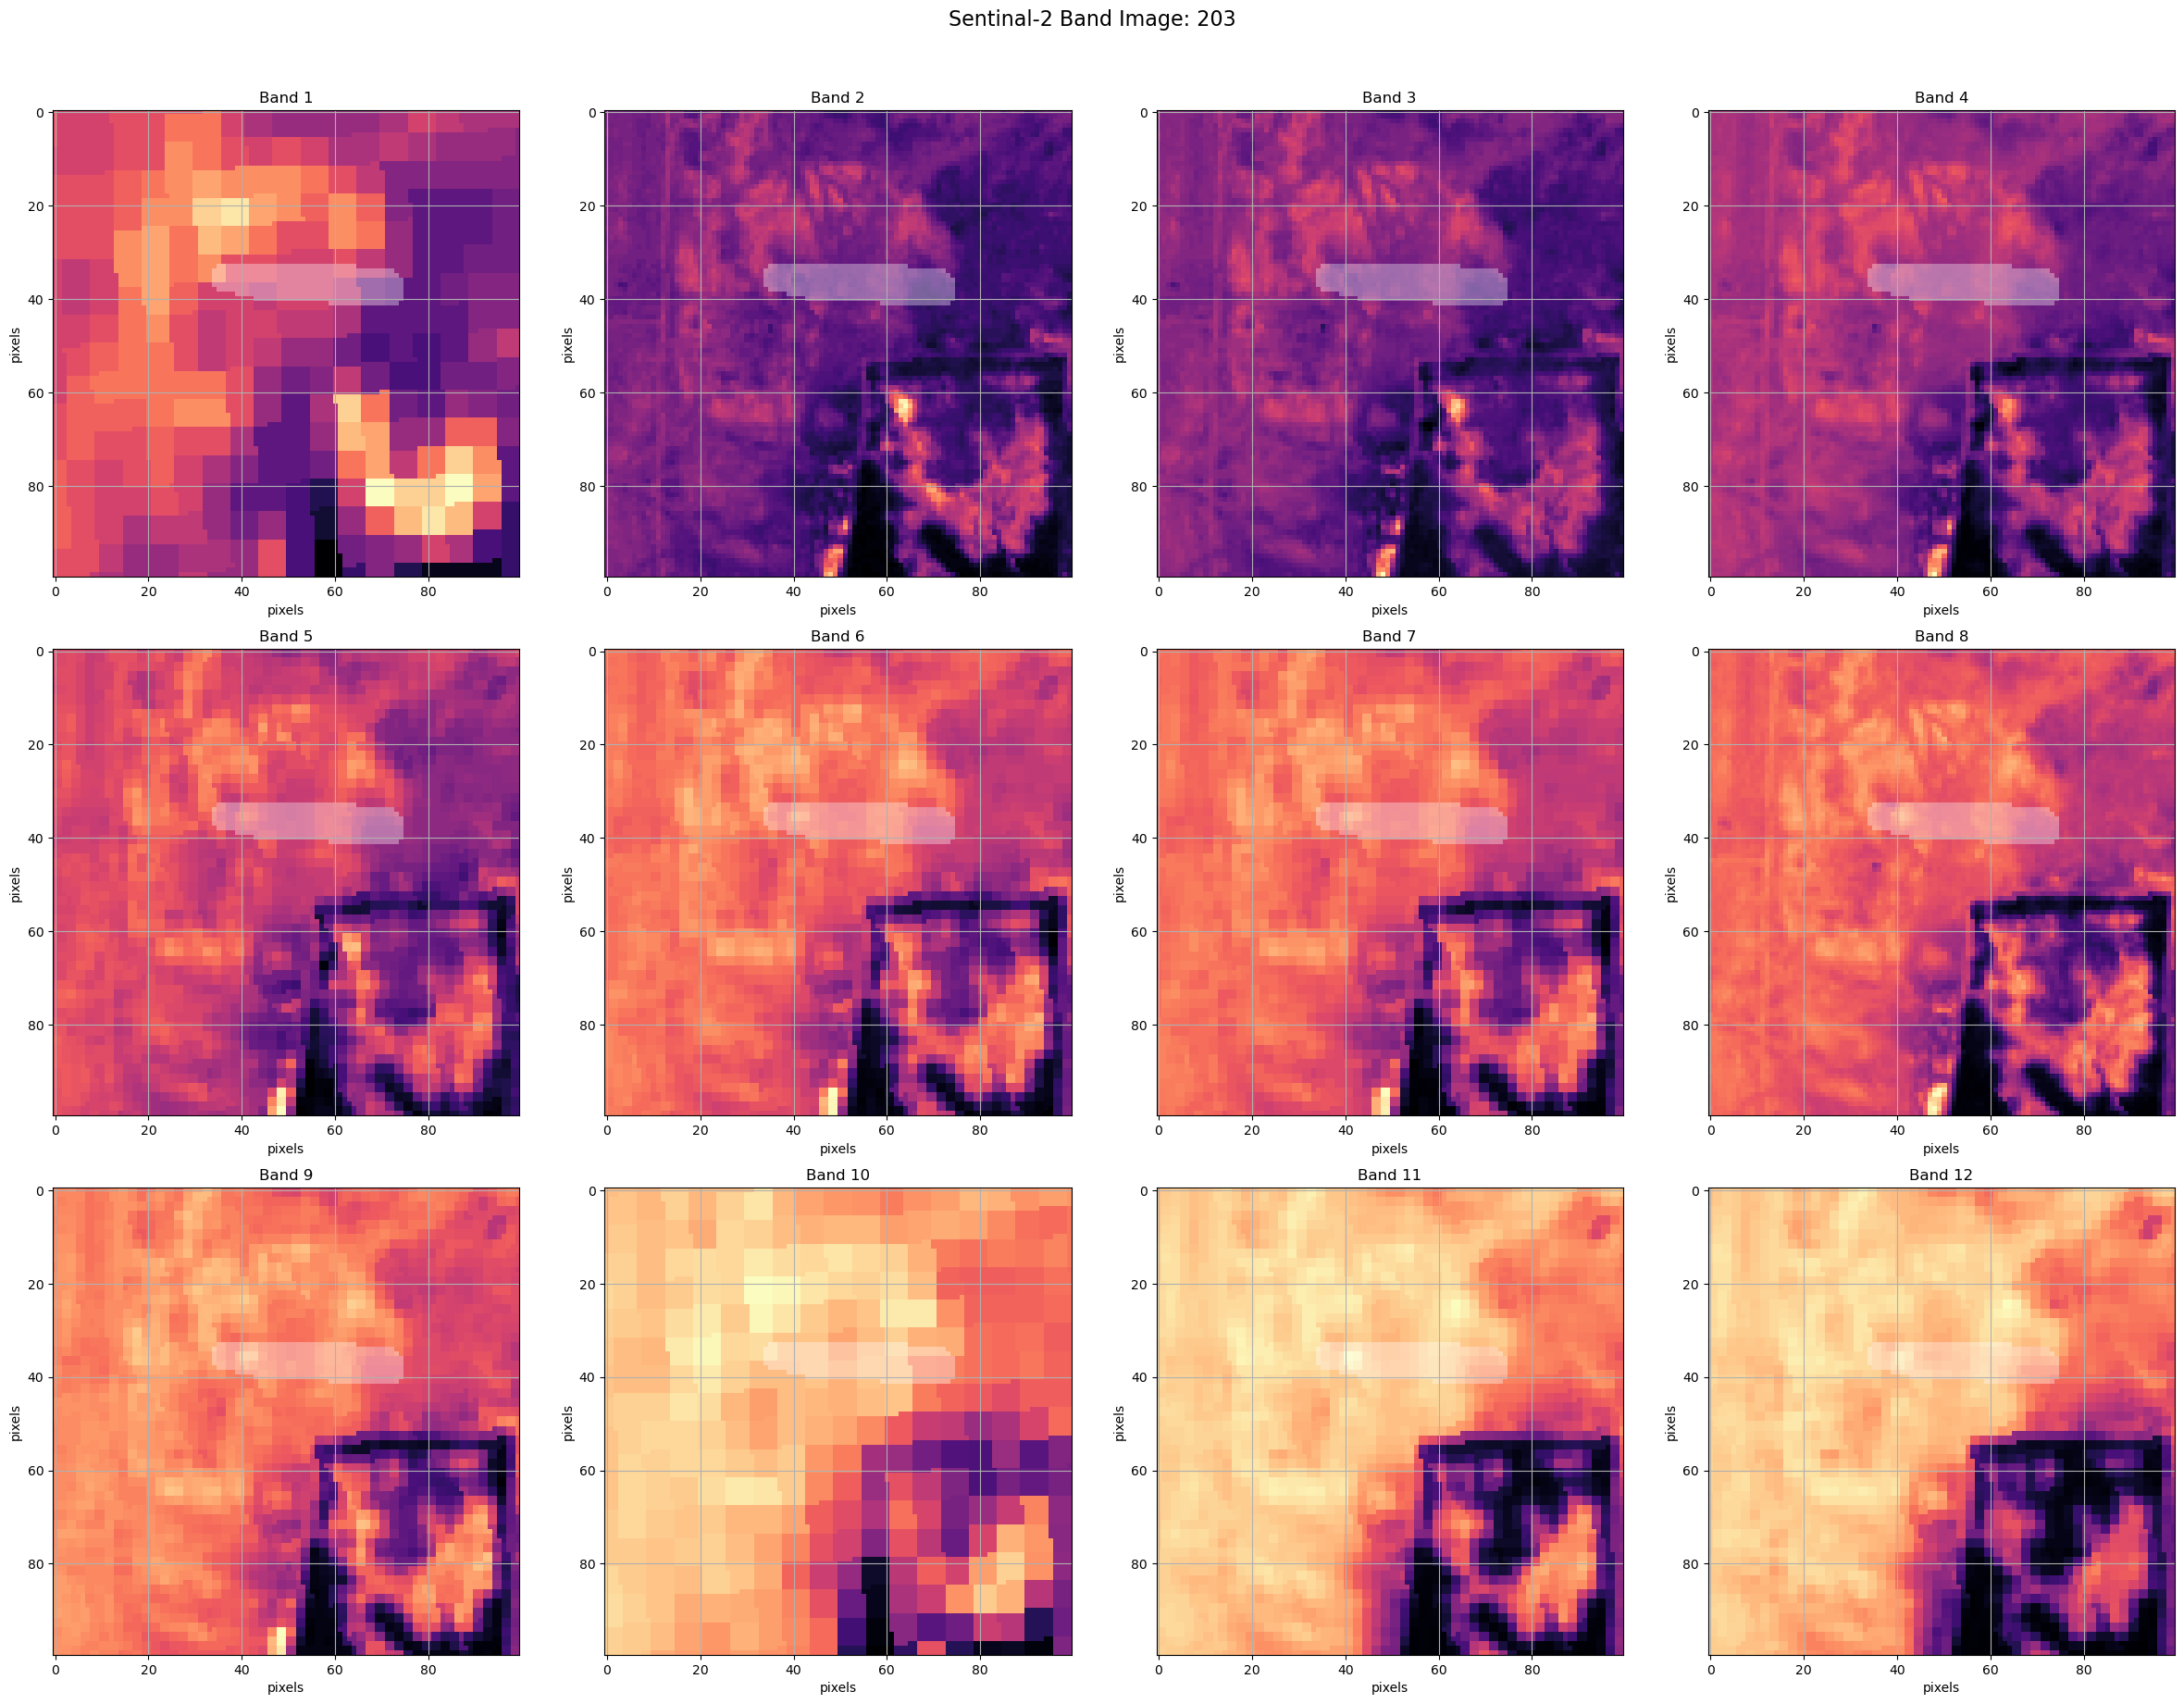

In [42]:
# Plot an example of all the Sentinal 2 band images (from the stored/supplied dataset)
plot_s2_masked(s2_roi,mask_roi)

---

### 2. Model Architecture

The detection model constructed by the authors in the original paper uses a simple and flexible UNet architecture (Ronneberger et al., 2015).

<center>
    <img src="unet_architecture.png" alt="Schematic of the CH4Net model architecture showing the Sentinel-2 bands' input to the UNet and probabilistic output compared to the hand-annotated mask. Figure 3 from original paper" style="width:700px;"/>
</center>

A UNet Neural Network is a type of deep learning model primarily used for image segmentation, where the goal is to identify and label different parts of an image, such as identifying objects, regions, or boundaries within the image. It's especially popular in medical image processing, but its structure makes it useful in various tasks where precise pixel-level predictions are needed. The UNet shares some similaraties to the Autoencoder network. They are both used for different purposes however and have key differences on how they handle data. Both architectures consist of an encoder (downsampling data) and a decoder (upsampling), but the main differences come from how they handle the data and what they are designed to achieve.

1. UNet
The UNet is designed for image segmentation, that is, labelling each pixel in the input image as belogning to a specific class (eg, identifying different objects or regions witihn an image). This is often used in medical or satellite image analysis where precise pixel-level classification is needed. The output is typically a segmented version of the input image, not a reconstruction. UNets are typically trained in a supervised manner where labeled data is provided ie Each pixel in the training images has a corresponding label (eg what object or region is belongs to). There are several other variants relating to image segmentation such as R-CNN / Mask R-CNN and the YOLO family of models (the later was explored in one of the on-site training exercises.) UNet's are particularly useful when you need find-grained segmentation, The R-CNN models for high quaility object detection and segmentation and the YOLO models for real-time performance in object detection tasks.

2. Autoencoder
The main purpose of an autoencoder is to learn compact representations of the input (latent space) and then reconstruct the original input from this compressed version. It is therefore useful in tasks like dimensionality reduction, denoising and unsupervised feature learning. Autoencoders are often trained in an unsupervised fashion, meaning they dont require labelled data. The model is trained to minimise the differences between the input and its output. Another useful use of Autoencoders is therefore in anomaly detection as the reconstructed signal during an anomalous event presents itself with differences to reconstructed dataset. 

For this example I will be focusing on constructing in PyTorch a UNet for use in segmenting out the methane plumes in the images based upon the training masks provided (supervised training task).

A UNet consists of Two Main Paths:

* Downsampling (Contracting Path): The left side of the "U" shape. This part of the network is similar to a regular convolutional neural network (CNN). It gradually reduces the size of the image by extracting features (like edges, textures, or patterns), but it loses some of the finer details. It's like zooming out on an image to see the bigger picture but losing some sharpness.

* Upsampling (Expanding Path): The right side of the "U". After reducing the image size, the network then works to expand it back to its original size by "upsampling." This part restores the fine details it lost earlier. Imagine zooming back in while trying to regain the details you missed.

### Details of the Downsampling Path:
In the author's example the downsampling path consisted of four encoder blocks. These were a 2D convolution layer, a batch norm a ReLU activation and a max pooling layer. These will all be discussed in the following section

As we know a Neural network is made up of many different types of 'blocks' each performing a certain function or mathmatical operation on the data flowing through the neural network.

##### 2D Convolutional Layer
A 2D convolutional layer is a fundamental building block of convolutional neural networks (CNNs), which are commonly used for processing images. It helps the network learn features from images, such as edges, shapes, and textures, which are crucial for tasks like image classification, object detection, and segmentation.

The input to the 2D convolutional layer is typically a grayscale or color image represented as a 2D array (or matrix) of pixel values.
For a grayscale image, each pixel is represented by a single value (intensity), while a color image has three channels (red, green, blue).

A filter (or kernel) is a small matrix (e.g., 3x3 or 5x5) that slides over the input image. This convolution operation calculates a dot product between the filter and the section of the image it overlaps with. The process is repeated for every position of the filter on the image. This creates a new 2D array (feature map) that represents the presence of features detected by the filter.

<center>
    <img src="2D_conv.gif" alt="Animation depicting 2D convolution" style="width:250px;"/>
    <p>The example shows a simple 3x3 filter being applied to an image</p>
</center>


##### Batch Norm Layer
The next layer used is the Batch Normalisation block. Batch Normalisation is a technique used to normalise the output of a previous layer in a neural network by adjusting and scaling the activations. It was introduced to address issues that arise during training, such as internal covariate shift<sup>2</sup>. Essentially, it helps stabilize and accelerate the training of deep neural networks. Specifically, for each feature (or channel) in the layer, it normalizes the output to have a mean of 0 and a variance of 1. The normalisation is calculated from the current batch rather than the entire dataset.


##### ReLU Activation
As Neural Networks are composed of multiple layers that perform linear transformations (e.g., weighted sums). Without an activation function, the output of each layer would just be a linear combination of the inputs. This limiting the model's ability to learn complex patterns. The Rectified Linear Unit or ReLU is one way of introducing non-linearity to the model, enabling it to learn complex relationships and representations in the data. This is crucial for tasks such as image recognition, natural language processing, and more. 

The ReLU activation function is one of the most widely used activation functions in neural networks, especially in convolutional neural networks (CNNs). It is defined mathmatically as and is shown below in the following picture: 

$$ReLU(𝑥)=max(0,𝑥)$$ 

<center>
    <img src="activation_functions.png" alt="Activation functions" style="width:550px;"/>
    <p>A selection of common activation functions used in constructing Neural Networks</p>
</center>

This means that if the input 𝑥 is greater than zero, ReLU returns 𝑥. If 𝑥 is less than or equal to zero, it returns 0.
Because ReLU outputs zero for any negative input, it creates sparse representations. Sparsity is beneficial because it can lead to more efficient computation and can help reduce the chances of overfitting by making the model simpler.

In deeper networks, ie those with multiple hidden layers, traditional activation functions like the sigmoid or tanh can suffer from the vanishing gradient problem, where gradients become too small for the model to learn effectively. ReLU does not saturate in the positive domain, allowing gradients to flow more easily during backpropagation, which facilitates faster learning and better performance in deeper networks. Hence why it is a very common choice of activation function within network architectures.


##### Max Pooling
`TODO`

### Details of the Downsampling Path:
`TODO`

---
<span style="font-size:0.8em;">Footnotes:</span>

<span style="font-size:0.8em;"><sup>2</sup> Internal covariate shift refers to the phenomenon where the distribution of inputs to a layer in a neural network changes during training as the parameters of the previous layers are updated. This occurs because as the weights of the network are adjusted (through the training process), the outputs of each layer change, leading to different input distributions for the layers that follow.</span>

---

### 3. PyTorch Model
We are importing two PyTorch submodules, `nn` provides the neural network methods to define the neural network while `optim` provides the optimizer methods which we will use to define how our training will be done.

`Dataset` this is used to store the samples and their corresponding labels.

`DataLoader` allows for the construction of a customised class used for loading in the datasets ie wrapping an iterable around the dataset.


In [43]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [55]:
# PyTorch Dataset classes for the Sentenal-2 Data from the test, train and validation folders
# Folders are then subdivided label, mbmp and s2 with futher positive and negative subdivision for 
# the supplied dataset.
# Folder locations in the __getitem__ method may need to be adjusted depending upon data location.
# This loads a single image
class SentinalMethaneDataset(Dataset):
    """
    A class used to contain in the Sentinal Methane Dataset
    """
    def __init__(self,mode,verbose=False):
        """
        Mode: str (test,train,val)
        """
        self.mode = mode
        self.verbose = verbose

        self.pos_ids = glob.glob(os.path.join('ch4net','split_{}'.format(mode),'label','positive', '*.npy'))
        self.neg_ids = glob.glob(os.path.join('ch4net','split_{}'.format(mode),'label','negative', '*.npy'))

        self.len_pos = len(self.pos_ids)
        self.len_neg = len(self.neg_ids)

        temp = self.pos_ids + self.neg_ids
        self.image_ids = [int(path.split('/')[-1].split('.')[0]) for path in temp]
        self.targets = mask = [1] * len(self.pos_ids) + [0] * len(self.neg_ids)
    
    def __len__(self):
        """
        Returns the number of samples in the dataset
        """
        return len(self.image_ids)
    
    def __getitem__(self,image_idx):
        """
        Loads and returns a sample from the dataset at 
        the given index, image_id.
        """
        image_id=self.image_ids[image_idx]
        if self.verbose:
            print("Loading ImageID/index: {}/{}".format(image_id,image_id))
        
        try:
            s2_path = "ch4net/split_{}/s2/positive/{}.npy".format(self.mode,image_id)
            mask_path = "ch4net/split_{}/label/positive/{}.npy".format(self.mode,image_id)
            s2 = np.load(s2_path)
            mask = np.load(mask_path)
        except:
            try:
                s2_path = "ch4net/split_{}/s2/negative/{}.npy".format(self.mode,image_id)
                mask_path = "ch4net/split_{}/label/negative/{}.npy".format(self.mode,image_id)
                s2 = np.load(s2_path)
                mask = np.load(mask_path)
            except:
                raise RuntimeError('No image {} found'.format(image_id))

        # Extract the 100x100 Region of interest from the image 
        # employed by the authors to prevent over-fitting
        mask_roi, s2_roi = self.slice_region(mask,s2)

        roi_dict = {'mode':self.mode,
                    'target': self.targets[image_idx],
                    'image_id':image_id,
                    'Mask_ROI':mask_roi,
                    'S2_ROI':s2_roi}
        
        return s2_roi, mask_roi
    
    def slice_region(self, mask, s2):
        # Size of the region to slice out
        slice_size = 100 
        if self.verbose:
            print(f"Original mask region: {mask.shape}")
            print(f"Original s2 region: {s2.shape}")

        if not (mask.shape[0] == s2.shape[0]) or not (mask.shape[1] == s2.shape[1])  :
            raise ValueError(f"Image dimensions of mask and s2 are not the same")
        
        n, m, d = s2.shape  # Get dimensions
        
        # Ensure that n and m are larger than 100 (the region size)
        if n < slice_size or m < slice_size:
            raise ValueError(f"Array dimensions n ({n}) and m ({m}) must be larger than the slice size ({slice_size}).")

        # Randomly select starting points, ensuring that the region stays within bounds
        start_n = np.random.randint(0, n - slice_size + 1)
        start_m = np.random.randint(0, m - slice_size + 1)

        # Slice the 100x100 region from the array
        mask_roi = mask[start_n:start_n + slice_size, start_m:start_m + slice_size]
        s2_roi = s2[start_n:start_n + slice_size, start_m:start_m + slice_size, :]

        # Print the start and end points of the sliced region for verification
        if self.verbose: 
            print(f"Selected region starts at (n={start_n}, m={start_m}) and ends at (n={start_n + slice_size}, m={start_m + slice_size})")
            print(f"Sliced region shape: {s2_roi.shape}")


        return mask_roi, s2_roi

In [56]:
train_dataset = SentinalMethaneDataset('train')

In [57]:
# Extend the custom SentinalMethaneLoader by now also using the 
# PyTorch DataLoader class from torch.utils.data. 
# This handles batching, shuffling and loading multiple samples in parallel.
def create_weighted_sampler(dataset):
    targets = dataset.targets
    class_counts = np.bincount(targets)
    class_weights = 1.0/class_counts
    sample_weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights),replacement=True)
    return sampler    

In [58]:
# Set the device that will be used to perform the training
# If an NVIDA graphics card is present utilise the CUDA acceleration
# If working on an Apple silcon mac eg M1, M2 use MPS acceleration
# Otherwise default to CPU based calculations.
device = (
   'cuda' if torch.cuda.is_available()
   else 'mps'
   if torch.backends.mps.is_available()
   else 'cpu')
print(f'Using {device = }')

# Force to CPU due to issue with mps on M1 Macbook
device='cpu'
print(f'Override to now use use {device = }')


Using device = 'mps'
Override to now use use device = 'cpu'


In [59]:
# Following UNet was built by ChatGPT by providing the 
# architecture details of the model from the paper.

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_device(device)
print(torch.get_default_device())

class UNet_GPT(nn.Module):
    """
    UNet model created by ChatGPT for pixel-wise classification (e.g., detecting methane plumes).
    
    This model is based on the original UNet architecture (Ronneberger et al., 2015) and consists of:
    - An encoder (down-sampling path) with four blocks, each containing two convolutional layers.
    - A decoder (up-sampling path) with four blocks, each containing transposed convolution and two convolutional layers.
    - Skip connections between encoder and decoder blocks of corresponding spatial resolutions.
    
    Attributes:
    -----------
    in_channels: int
        The number of input channels (e.g., 12 for Sentinel-2 imagery).
    out_channels: int
        The number of output channels (1 for binary classification).
    """
    
    def __init__(self, in_channels, out_channels):
        """
        Initializes the UNet model by setting up the encoder, decoder, and final output layer.
        
        Parameters:
        -----------
        in_channels: int
            The number of input channels (e.g., 12 for Sentinel-2 imagery).
        out_channels: int
            The number of output channels (e.g., 1 for binary prediction).
        """
        super(UNet_GPT, self).__init__()

        # Define a two-convolutional layer block with BatchNorm and ReLU
        def double_conv(in_ch, out_ch):
            """
            Creates a block with two convolutional layers, each followed by BatchNorm and ReLU activation.
            
            Parameters:
            -----------
            in_ch: int
                Number of input channels for the block.
            out_ch: int
                Number of output channels for the block.
            
            Returns:
            --------
            nn.Sequential
                A sequence of two convolutional layers with batch normalization and ReLU activation.
            """
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Define a down-sampling block (convolution + max pooling)
        def down_block(in_ch, out_ch):
            """
            Creates a block for down-sampling using a double convolution followed by max-pooling.
            
            Parameters:
            -----------
            in_ch: int
                Number of input channels for the down block.
            out_ch: int
                Number of output channels for the down block.
            
            Returns:
            --------
            nn.Sequential
                A sequence of a double convolution block followed by max pooling.
            """
            return nn.Sequential(
                double_conv(in_ch, out_ch),
                nn.MaxPool2d(kernel_size=2)
            )

        # Define an up-sampling block using ConvTranspose2d (upsampling) followed by a double convolution
        class UpBlock(nn.Module):
            """
            A custom module for the up-sampling part of UNet (decoder).
            It upsamples the input using a transpose convolution and then performs a double convolution.
            """
            def __init__(self, in_ch, out_ch):
                """
                Initializes the UpBlock.
                
                Parameters:
                -----------
                in_ch: int
                    Number of input channels (from both the upsampled layer and the skip connection).
                out_ch: int
                    Number of output channels for the block.
                """
                super(UpBlock, self).__init__()

                # Transposed convolution for upsampling the feature maps
                self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

                # Double convolution for further feature extraction
                self.conv = double_conv(in_ch, out_ch)

            def forward(self, x1, x2):
                """
                Defines the forward pass of the up-sampling block.
                
                Parameters:
                -----------
                x1: torch.Tensor
                    The input tensor from the previous decoder layer (after upsampling).
                x2: torch.Tensor
                    The input tensor from the corresponding encoder block (skip connection).
                
                Returns:
                --------
                torch.Tensor
                    The output after concatenating x1 and x2, and applying double convolution.
                """
                # Upsample the input feature map
                x1 = self.up(x1)

                # Calculate the difference in spatial dimensions and pad accordingly
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]
                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

                # Concatenate along the channel dimension (dim=1)
                x = torch.cat([x2, x1], dim=1)

                # Apply the double convolution
                return self.conv(x)

        # Encoder: Downsampling path
        self.inc = double_conv(in_channels, 64)      # Initial block
        self.down1 = down_block(64, 128)             # Down block 1
        self.down2 = down_block(128, 256)            # Down block 2
        self.down3 = down_block(256, 512)            # Down block 3
        self.down4 = down_block(512, 1024)           # Down block 4 (deepest)

        # Decoder: Upsampling path
        self.up1 = UpBlock(1024, 512)                # Up block 1 (from 1024 to 512)
        self.up2 = UpBlock(512, 256)                 # Up block 2
        self.up3 = UpBlock(256, 128)                 # Up block 3
        self.up4 = UpBlock(128, 64)                  # Up block 4

        # Final 1x1 convolution layer to map to the desired number of output channels
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Defines the forward pass of the UNet model.
        
        Parameters:
        -----------
        x: torch.Tensor
            The input tensor (e.g., an image or Sentinel-2 bands).
        
        Returns:
        --------
        torch.Tensor
            The output tensor after the forward pass, representing the pixel-wise classification.
        """
        # Encoder (down-sampling)
        x1 = self.inc(x)         # Initial feature extraction
        x2 = self.down1(x1)      # Downsample and extract features
        x3 = self.down2(x2)      # Continue downsampling
        x4 = self.down3(x3)      # Deeper layers
        x5 = self.down4(x4)      # Deepest layer

        # Decoder (up-sampling)
        x = self.up1(x5, x4)     # First up-sampling and skip connection
        x = self.up2(x, x3)      # Second up-sampling and skip connection
        x = self.up3(x, x2)      # Third up-sampling and skip connection
        x = self.up4(x, x1)      # Final up-sampling and skip connection

        # Final output layer (1x1 convolution)
        logits = self.outc(x)

        # Apply sigmoid activation for binary classification (probability output between 0 and 1)
        return torch.sigmoid(logits)


# Example usage:
# Input dimensions (Sentinel-2 bands: 12 channels, 100x100 image)
in_channels = 12  # Number of input channels
out_channels = 1  # Output for binary classification (1 channel)

# Instantiate the model
model = UNet_GPT(in_channels, out_channels)

# Test the model with a random tensor (batch_size, channels, height, width)
dummy_input = torch.randn(1, in_channels, 100, 100)
output = model(dummy_input)
print(output.shape)  # Should be (1, 1, 100, 100)

cpu
torch.Size([1, 1, 100, 100])


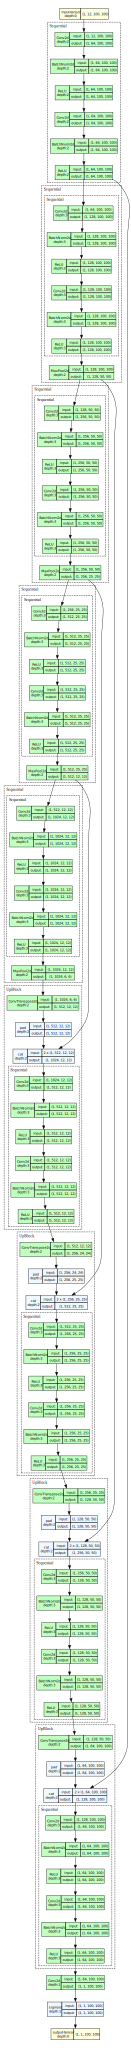

In [60]:
from torchview import draw_graph
# Create a random tensor with the same shape as the input (batch_size, in_channels, height, width)
dummy_input = torch.randn(1, in_channels, 100, 100)

# Use torchview's draw_graph to visualize the model architecture
graph = draw_graph(model, input_data=dummy_input, expand_nested=True,graph_dir='TB')
graph.visual_graph  # This will render the network structure

---
# 4 Model Training, Testing
We now have a U-net model for segmentation, a data loader for the ground truth images and masks (that get then split out into a 100x100 region of interest) and from the authors we have a training, testing and validation population. The next step is then to train the model on the data by initiating a training run.

### Optimiser discussion
`TODO`

### Loss Function discussion
The loss function of Binary cross-entropy is used. However in this instance instead of using `nn.BCELoss()` we use `nn.BCEWithLogitsLoss()`. This function combines a *sigmoid activation* and *binary cross-entropy loss* into a single operation. This expects raw, unnormalised logits (ie real-valued numbers) as input, and internally applies the sigmoid function. This is more numerically stable, especially when dealing with very high or very low values in the output.

Many segmentation datasets are imbalanced, meaning there may be significantly more background pixels than object (foreground) pixels. By using `(reduction="none")`, we can weight the loss for certain pixels differently to account for this imbalance.

Using BCEWithLogitsLoss() is the preferred choice over BCELoss() in most cases. It allows you to pass logits (raw network outputs) directly, provides better numerical stability, and is more efficient. It is especially useful in image segmentation tasks where the model predicts the probability of each pixel belonging to a class (i.e., foreground/background)

In [61]:
# Training Hyperparameters
# Set the Loss and Optimisation functions
LEARNING_RATE = 0.001 # Set the learning rate for the optimiser
optimiser = optim.Adam(model.parameters(), lr=0.001)
loss_criterion = nn.BCEWithLogitsLoss(reduction='mean') 

from sklearn.metrics import accuracy_score
# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [69]:
# Set the model to training mode
model.train()

# Load the train, test and validation datasets
EPOCHS = 20
BATCH_SIZE = 1

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

train_dataset = SentinalMethaneDataset('train')
test_dataset = SentinalMethaneDataset('test')

train_sampler = create_weighted_sampler(train_dataset)

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [70]:
from datetime import datetime
for epoch in range(EPOCHS):
    start_time = datetime.now()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images,masks in train_loader:
        images = images.permute(0, 3, 1, 2)
        images = images.float()
        masks = masks.float()
        # Add channel dimension to masks
        masks = masks.unsqueeze(1) # Make it [batch_size, 1, height, width]

        # Move tensors to correct device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimiser.zero_grad() 

        # Forward pass
        predictions = model(images)
        # Calcualte the loss
        loss = loss_criterion(predictions,masks)
        
        # Backward pass and optimisation
        loss.backward()
        optimiser.step()

        # Metrics calculation
        train_loss += loss.item() * images.size(0)
        train_total += masks.numel()
        # train_correct += calculate_accuracy(masks, outputs) * masks.numel()
    train_loss = train_loss/train_total
    
    train_loss_history.append(train_loss)

    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.permute(0, 3, 1, 2)
            images = images.float()
            masks = masks.float()
            # Add channel dimension to masks
            masks = masks.unsqueeze(1) # Make it [batch_size, 1, height, width]

            # Move tensors to correct device
            images = images.to(device)
            masks = masks.to(device)

            predictions = model(images)
            loss = loss_criterion(predictions,masks)

            test_loss += loss.item() * images.size(0)
            test_total += masks.numel()
    test_loss = test_loss / test_total

    test_loss_history.append(test_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Time Taken: {datetime.now()-start_time}")
print(f"Total Time Taken: {datetime.now()-start_time}")


Epoch [1/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:59.762372
Epoch [2/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:59.520066
Epoch [3/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:58.772232
Epoch [4/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:58.921453
Epoch [5/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:01:00.666674
Epoch [6/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:59.969134
Epoch [7/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:01:01.270459
Epoch [8/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:01:04.735281
Epoch [9/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:59.859907
Epoch [10/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:58.517626
Epoch [11/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:58.122834
Epoch [12/20], Train Loss: 0.0001, Test Loss: 0.0001, Time Taken: 0:00:58.727277
Epoch [13/20], Train Loss: 0.0001, Te

As can be seen above something I've setup isnt working properly. This could be the dataset, the model or the implementation of the pytorch training of the model. As the train and test loss isnt changing ! :(

In [ ]:
# Accuracy plots, confusion matricies etc

---
# 5 Model Validation

---
# 6 Model Inference on New Data
Demonstrate running the model on the validation hold out dataset & then also demonstrate obtaining some new data from Sentinal-2 and running this through the model.

---
# 7 Discussion on Hyperparameter Tuning

---
# 8 Model conversion to TinyML for deployment
Work on a conversion of the model to TinyML for deployment on one of the arduino's. Experiement so that that data is "processed" on-board and after an image is presented either a message saying "No Detection" is transmitted or the dataset and mask are returned as part of an alert. In the simuation data should be sent as though recived by imaging sensors at the edge for local processing by the on board computing device.


---